In [3]:
# 问题四：考虑企业综合实力的加权展位分配
import pandas as pd
from src.scheduler.booth_data_loader import load_booth_schedule
from src.scheduler.weighted_allocator import allocate_booths_weighted
from src.scheduler.validate_assignment import validate_schedule
from src.scheduler.output_formatter import print_schedule_table, plot_assignment_distribution
from src.utils.selection import calculate_scores

# 设置中文字体与警告屏蔽
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
schedule = load_booth_schedule("../../data/booth_schedule.json")
enterprise_df = pd.read_csv("../../data/selected_enterprises.csv")
full_info_df = pd.read_csv("../../data/enterprise_info.csv")

In [5]:
# 企业代号 => 企业编号
code_to_id = dict(zip(enterprise_df['企业代号'], enterprise_df['企业编号']))
id_to_code = dict(zip(enterprise_df['企业编号'], enterprise_df['企业代号']))

# 获取综合评分（编号为键）
filtered_info = full_info_df[full_info_df['企业编号'].isin(code_to_id.values())]
score_map_raw = calculate_scores(filtered_info)

# 映射为代号为 key 的 score_map
score_map = {
    id_to_code[eid]: score_map_raw[eid]
    for eid in code_to_id.values()
}

In [6]:
# 分配展位（加权策略）
assignment = allocate_booths_weighted(schedule, enterprise_df, score_map)

In [7]:
# 打印展位分配表格
print_schedule_table(assignment)

                        A1                            A2    B1          B2
周一                    A x4                          A x5  B x1  A x1, B x1
周二              A x2, B x2                    A x3, B x2  B x1  A x1, B x1
周三              A x2, B x2        F x2, A x1, C x1, B x1  A x1  E x1, C x1
周四  B x1, F x1, A x1, E x1  B x1, C x1, F x1, D x1, A x1  E x1  B x1, C x1
周五  F x1, D x1, G x1, A x1        E x1, B x1, C x1, A x1  D x1            


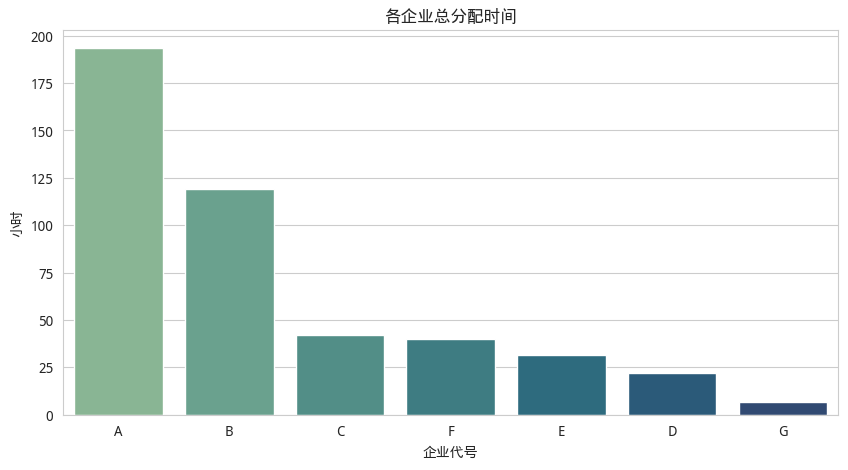

In [8]:
# 可视化：展示每个企业分配时间条形图
plot_assignment_distribution(assignment, enterprise_df)

In [9]:
# 验证结果是否满足需求下限
validate_schedule(assignment, enterprise_df)

### 模型说明（基于企业综合实力打分的加权分配策略）：
为体现“强者优先”的原则，在展位资源有限的情况下，我们根据每家企业的综合评分结果动态调整 booth 分配优先级。

设第 \( i \) 家企业的实力评分为 \( s_i \)，当前剩余需求企业集合为 \( R \)。

每次分配一个展位前，我们对 \( R \) 中所有企业计算加权概率：

$$
P_i = \frac{s_i}{\sum\limits_{j \in R} s_j}
$$

然后从中选出概率最大的企业（或按概率进行轮盘赌），分配该 booth。如此迭代分配所有展位。

 本方法始终确保企业最终分配时间  最低需求（即：需求 - 可接受缺额），并尽量让高分企业获得更多展示时间。

此方法更贴近实际招商原则，能引导高质量企业参与展会，从而提升整体品牌价值与媒体关注度。